In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


dataset/2.csv
dataset/1.csv
dataset/0.csv
dataset/3.csv


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
import torchvision
import torchvision.transforms as transforms
from ray import tune
from ray import train
from ray.train import Checkpoint, get_checkpoint
from ray.tune.schedulers import ASHAScheduler
import ray.cloudpickle as pickle
from functools import partial
import tempfile
from pathlib import Path

In [4]:
# Four classes of motion were written from MYO armband with the help of our app https://github.com/cyber-punk-me/nukleos.
# The MYO armband has 8 sensors placed on skin surface, each measures electrical activity produced by muscles beneath.

# Each dataset line has 8 consecutive readings of all 8 sensors. so 64 columns of EMG data. 
# The last column is a resulting gesture that was made while recording the data (classes 0-3)
# So each line has the following structure:
# [8sensors][8sensors][8sensors][8sensors][8sensors][8sensors][8sensors][8sensors][GESTURE_CLASS]
# Data was recorded at 200 Hz, which means that each line is 8*(1/200) seconds = 40ms of record time.

# A classifier given 64 numbers would predict a gesture class (0-3).
# Gesture classes were : rock - 0, scissors - 1, paper - 2, ok - 3. 
# Rock, paper, scissors gestures are like in the game with the same name, and OK sign is index finger touching the thumb and the rest of the fingers spread. 
# Each gesture was recorded 6 times for 20 seconds. Each time recording started with the gesture being already prepared and held. 
# Recording stopped while the gesture was still being held. In total there is 120 seconds of each gesture being held in fixed position. 
# All of them recorded from the same right forearm in a short timespan. 
# Every recording of a certain gesture class was concatenated into a .csv file with a corresponding name (0-3).

df0 = pd.read_csv("dataset/0.csv", header=None)
print("Class 0 Shape", df0.shape)
df1 = pd.read_csv("dataset/1.csv", header=None)
print("Class 1 Shape", df1.shape)
df2 = pd.read_csv("dataset/2.csv", header=None)
print("Class 2 Shape", df2.shape)
df3 = pd.read_csv("dataset/3.csv", header=None)
print("Class 3 Shape", df3.shape)

df = pd.concat([df0,df1,df2,df3])
print("Combined Shape", df.shape)
data = df.values

sc = MinMaxScaler(feature_range = (0, 1))

Class 0 Shape (2910, 65)
Class 1 Shape (2903, 65)
Class 2 Shape (2943, 65)
Class 3 Shape (2922, 65)
Combined Shape (11678, 65)


(23280, 4)


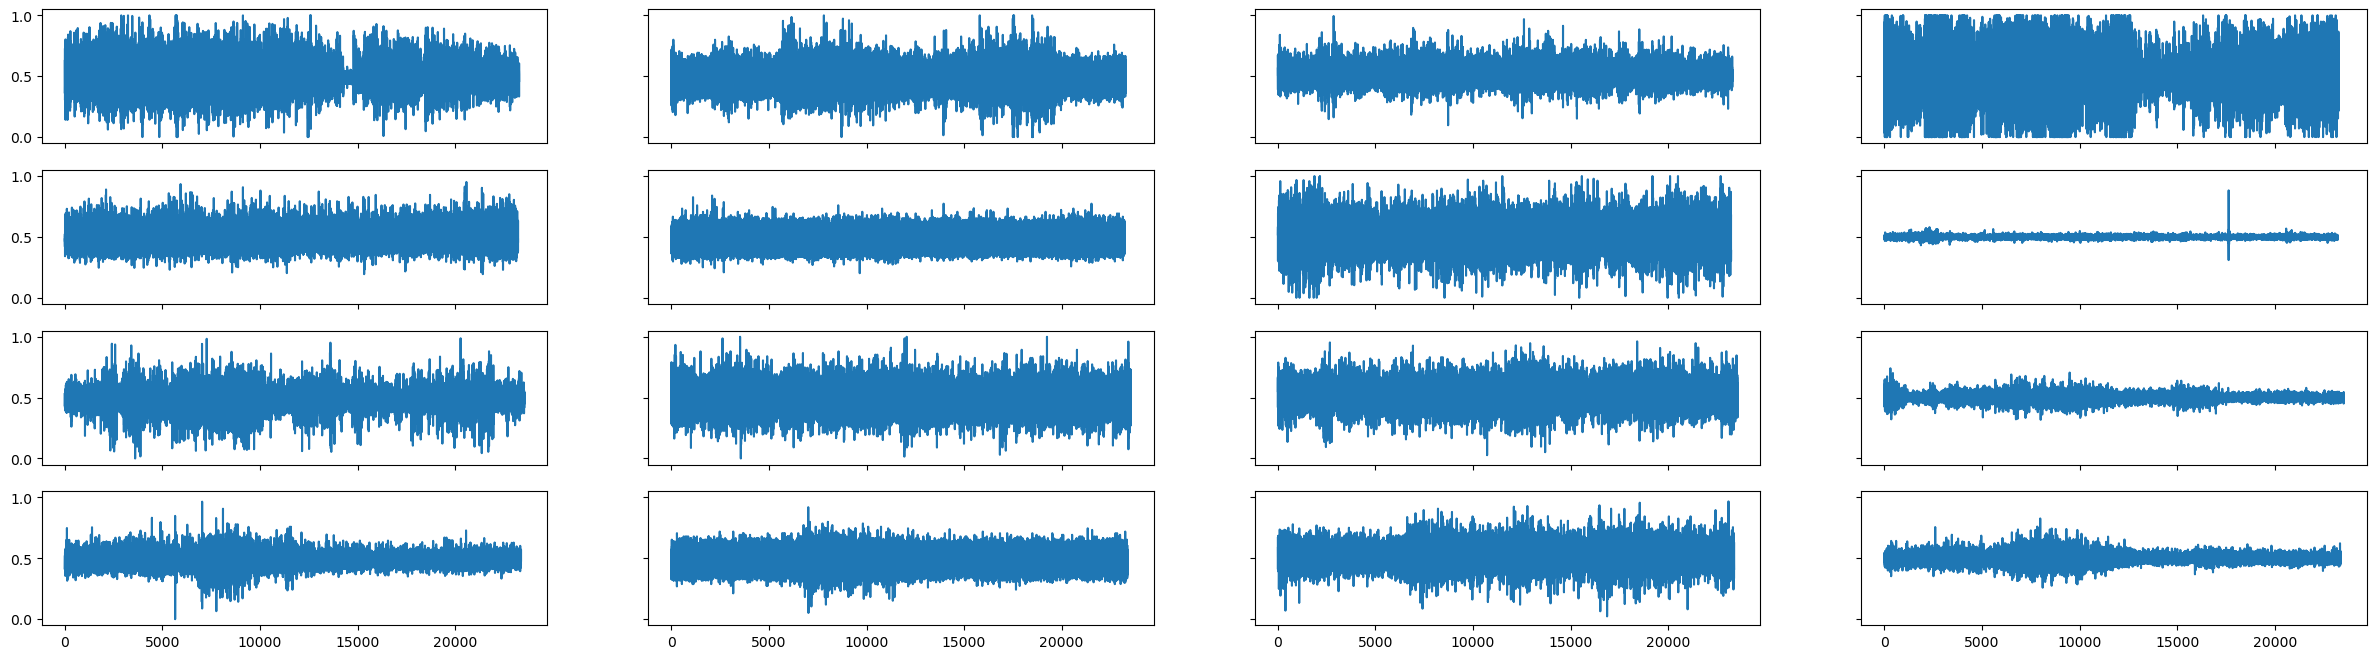

In [5]:
def plot_data(data):
    
    X0, X1, X2, X3=[],[],[],[]
    data[:,:-1] = sc.fit_transform(data[:,:-1])
    
    for i in range(data.shape[0]):
        tmp = data[i,:-1].reshape((8,8))
        # Each dataset line has 8 consecutive readings of all 8 sensors. so 64 columns of EMG data. 
        # The last column is a resulting gesture that was made while recording the data (classes 0-3) 
        # So each line has the following structure:
        # [8sensors][8sensors][8sensors][8sensors][8sensors][8sensors][8sensors][8sensors][GESTURE_CLASS]
        for j in range(8):
            
            if data[i,-1] == 0:
                X0.append([tmp[j][s] for s in range(0, 8, 2)])
            
            elif data[i,-1] == 1:
                X1.append([tmp[j][s] for s in range(0, 8, 2)])
            
            elif data[i,-1] == 2:
                X2.append([tmp[j][s] for s in range(0, 8, 2)])
                # X2.append(tmp[j,:])

            elif data[i,-1] == 3:
                X3.append([tmp[j][s] for s in range(0, 8, 2)])
                # X3.append(tmp[j,:])
    
    X0, X1, X2, X3 = np.array(X0), np.array(X1), np.array(X2), np.array(X3)    
    print(X0.shape)
        
    fig, axes = plt.subplots(4,4, figsize=(30, 8), sharex=True, sharey=True)
    # for i in range(8):
    for i in range(4):
        axes[0][i].plot(X0[:,i], label='Raw Ch '+str(i))
        axes[1][i].plot(X1[:,i], label='Raw Ch '+str(i))
        axes[2][i].plot(X2[:,i], label='Raw Ch '+str(i))
        axes[3][i].plot(X3[:,i], label='Raw Ch '+str(i))
        
# vertical axis defines the EMG signal amplitude, and the horizontal axis defines the time.
# Vertical arrangement of the plots represents the 4 classes of gestures.
# Horizontal arrangement of the plots represents the (trimmed 8) 4 channels of EMG data.
plot_data(data)

In [6]:
class PureLSTM(nn.Module):
    
    # we can optimize hidden units, sequence length, number of layers, and hidden features
    def __init__(self, n_features=4, n_hidden=16, n_sequence=8, n_layers=1, n_classes=4, hidden_features=128, dropout0=False):
        super(PureLSTM, self).__init__()
        
        self.n_features = n_features
        self.n_hidden = n_hidden
        self.n_sequence = n_sequence
        self.n_layers = n_layers
        self.n_classes = n_classes
        
        self.lstm = nn.LSTM(input_size=n_features, hidden_size=n_hidden, num_layers=n_layers, batch_first=True)
        self.dropout0 = None
        if dropout0:
            self.dropout0 = nn.Dropout(p=0.2)
        self.linear_1 = nn.Linear(in_features=n_hidden, out_features=hidden_features)
        self.dropout_1 = nn.Dropout(p=0.2)
        
        self.linear_2 = nn.Linear(in_features=hidden_features, out_features=n_classes)        
        
    
    def forward(self, x):
        self.hidden = (
            torch.zeros(self.n_layers, x.shape[0], self.n_hidden).to(device),
            torch.zeros(self.n_layers, x.shape[0], self.n_hidden).to(device)
        )
    
        out, (hs, cs) = self.lstm(x.view(len(x), self.n_sequence, -1),self.hidden)
        out = out[:,-1,:]
        if self.dropout0:
            out = self.dropout0(out)
        out = self.linear_1(out)
        out = self.dropout_1(out)
        out = self.linear_2(out)
        
        return out
    
def train_model(model, train_dataloader, n_epochs=200, lr=0.01):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr) # was 0.001
    
    for epoch in range(n_epochs):

        for i, (X_train, y_train) in enumerate(train_dataloader):
            
            y_hat = model(X_train)
            
            loss = loss_fn(y_hat.float(), y_train)

            if i == 0 and (epoch+1)%10==0:
                print(f'Epoch {epoch+1} train loss: {loss.item()}')

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()
        
    return model

In [7]:
def select_4_channels(data):
    X = []
    for i in range(data.shape[0]):
        tmp = data[i]
        for j in range(8):
            X.append([tmp[j][s] for s in range(0, 8, 2)])
    return np.array(X).reshape(-1,8,4)

def prepare_data(data):
    data[:,:-1] = sc.fit_transform(data[:,:-1])
    np.random.shuffle(data)
    X, y = data[:,:-1], data[:,-1]
    X = X.reshape(-1,8,8)
    X = select_4_channels(X)
    print("X prepared shape", X.shape)
    
    X_train = torch.from_numpy(X[:7700])
    y_train = torch.from_numpy(y[:7700])
    X_test = torch.from_numpy(X[7700:])
    y_test = torch.from_numpy(y[7700:])
    
    return X_train.float().to(device), y_train.long().to(device), X_test.float().to(device), y_test.long().to(device)

In [8]:
class EmgDataset(Dataset):
    
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    
    def __len__(self):
        return self.X.shape[0]
    
    
# n_features=4
# n_sequence=8
# n_hidden=16
# n_layers=2
# n_classes=4

# n_epochs = 400
# n_batch_size = 256

# model = PureLSTM(n_features, n_hidden, n_sequence, n_layers, n_classes).to(device)
# X_train, y_train, X_test, y_test = prepare_data(data, n_sequence)

# print("Train Data Shape ",X_train.shape, y_train.shape)
# print("Test Data Shape ",X_test.shape, y_test.shape)

# train_dataset = EmgDataset(X_train, y_train)
# train_dataloader = DataLoader(dataset = train_dataset, batch_size=n_batch_size, shuffle=True)
# model = train_model(model, train_dataloader, n_epochs = n_epochs)

In [9]:
def train_hyper(config, data_dir=None):
    n_features=4
    n_classes=4
    n_sequence=8
    n_hidden=config['n_hidden']
    n_layers=config['n_layers']

    n_epochs = config['n_epochs']
    n_batch_size = config['n_batch_size']

    model = PureLSTM(n_features, n_hidden, n_sequence, n_layers, n_classes).to(device)

    X_train, y_train, X_test, y_test = prepare_data(data)

    print("Train Data Shape ",X_train.shape, y_train.shape)
    print("Test Data Shape ",X_test.shape, y_test.shape)

    train_dataset = EmgDataset(X_train, y_train)
    train_dataloader = DataLoader(dataset = train_dataset, batch_size=n_batch_size, shuffle=True)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), config['lr']) # was 0.001
    
    checkpoint = get_checkpoint()
    if checkpoint:
        with checkpoint.as_directory() as checkpoint_dir:
            data_path = Path(checkpoint_dir) / "data.pkl"
            with open(data_path, "rb") as fp:
                checkpoint_state = pickle.load(fp)
            start_epoch = checkpoint_state["epoch"]
            model.load_state_dict(checkpoint_state["net_state_dict"])
            optimizer.load_state_dict(checkpoint_state["optimizer_state_dict"])
    else:
        start_epoch = 0

    for epoch in range(n_epochs):
        for i, (X_train, y_train) in enumerate(train_dataloader):
            y_hat = model(X_train)
            
            loss = loss_fn(y_hat.float(), y_train)

            if i == 0 and (epoch+1)%10==0:
                print(f'Epoch {epoch+1} train loss: {loss.item()}')

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    with torch.no_grad():
        y_hat_train = model(X_train)
        prediction = torch.argmax(y_hat_train, dim=1)
        good = 0
        for i in range(len(y_train)):
            if (prediction[i] == y_train[i]):
                good = good +1
        acc = (good/len(y_train)) * 100.0
        print("Train Accuracy ", acc)

        y_hat_test = model(X_test)
        prediction = torch.argmax(y_hat_test, dim=1)
        good = 0
        for i in range(len(y_test)):
            if (prediction[i] == y_test[i]):
                good = good +1
        acc = (good/len(y_test)) * 100.0
        print("Test Accuracy ", acc)
    
    checkpoint_data = {
            "epoch": epoch,
            "net_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
        }
    with tempfile.TemporaryDirectory() as checkpoint_dir:
        data_path = Path(checkpoint_dir) / "data.pkl"
        with open(data_path, "wb") as fp:
            pickle.dump(checkpoint_data, fp)
        checkpoint = Checkpoint.from_directory(checkpoint_dir)
        train.report(
            {"accuracy": acc},
            checkpoint=checkpoint,
        )


In [10]:
def evaluateModel(prediction, y):
    prediction = torch.argmax(prediction, dim=1)
    good = 0
    for i in range(len(y)):
        if (prediction[i] == y[i]):
            good = good +1
    return (good/len(y)) * 100.0


# with torch.no_grad():
#     y_hat_train = model(X_train)
#     print("Train Accuracy ", evaluateModel(y_hat_train, y_train))
    
#     y_hat_test = model(X_test)
#     print("Test Accuracy ", evaluateModel(y_hat_test, y_test))

In [ ]:
os.environ["TUNE_DISABLE_STRICT_METRIC_CHECKING"] = "1"

def main(num_samples=10, max_num_epochs=10, gpus_per_trial=0):
    data_dir = os.path.abspath("./hyper_params")
    config = {
        "n_hidden": tune.choice([2 ** i for i in range(1, 8)]),
        "n_layers": tune.choice([1, 2, 4, 8, 16]),
        "n_epochs": tune.choice([100, 200, 300, 400, 500, 600]),
        "n_batch_size": tune.choice([2 ** i for i in range(1, 9)]),
        "lr": tune.loguniform(1e-4, 1e-1),
    }

    scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2,
    )
    result = tune.run(
        partial(train_hyper, data_dir=data_dir),
        resources_per_trial={"cpu": 4, "gpu": gpus_per_trial},
        config=config,
        num_samples=num_samples,
        scheduler=scheduler,
    )

    best_trial = result.get_best_trial("loss", "min", "last")
    print(f"Best trial config: {best_trial.config}")
    print(f"Best trial final validation loss: {best_trial.last_result['loss']}")
    print(f"Best trial final validation accuracy: {best_trial.last_result['accuracy']}")

    n_features=4
    n_classes=4
    n_sequence=8
    n_hidden=best_trial.config['n_hidden']
    n_layers=best_trial.config['n_layers']
    
    best_trained_model = PureLSTM(n_features, n_hidden, n_sequence, n_layers, n_classes).to(device)

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if gpus_per_trial > 1:
            best_trained_model = nn.DataParallel(best_trained_model)
    best_trained_model.to(device)

    best_checkpoint = result.get_best_checkpoint(trial=best_trial, metric="accuracy", mode="max")
    with best_checkpoint.as_directory() as checkpoint_dir:
        data_path = Path(checkpoint_dir) / "data.pkl"
        with open(data_path, "rb") as fp:
            best_checkpoint_data = pickle.load(fp)

        best_trained_model.load_state_dict(best_checkpoint_data["net_state_dict"])

        X_train, y_train, X_test, y_test = prepare_data(data, n_sequence)
        y_hat_test = best_trained_model(X_test)
        acc = evaluateModel(y_hat_test, y_test)
        print("Best trial test set accuracy: {}".format(acc))


if __name__ == "__main__":
    # You can change the number of GPUs per trial here:
    main(num_samples=10, max_num_epochs=10, gpus_per_trial=0)

2024-11-19 23:28:02,092	INFO worker.py:1810 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
2024-11-19 23:28:03,523	INFO tune.py:253 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `tune.run(...)`.
2024-11-19 23:28:03,525	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


(raylet) Warning: The actor ImplicitFunc is very large (11 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.
(func pid=89614) X prepared shape (11678, 8, 4)
(func pid=89614) Train Data Shape  torch.Size([7700, 8, 4]) torch.Size([7700])
(func pid=89614) Test Data Shape  torch.Size([3978, 8, 4]) torch.Size([3978])
(func pid=89614) Epoch 10 train loss: 1.3880925178527832
(func pid=89612) X prepared shape (11678, 8, 4)
(func pid=89612) Train Data Shape  torch.Size([7700, 8, 4]) torch.Size([7700])
(func pid=89612) Test Data Shape  torch.Size([3978, 8, 4]) torch.Size([3978])
(func pid=89612) Epoch 10 train loss: 0.4917251467704773
(func pid=89614) Epoch 20 train loss: 1.3843564987182617
(func pid=89614) Epoch 30 train loss: 1.3846461772918701
(func pid=89612) Epoch 20 train loss: 0.6564139723777771
(func pid=89614) Epoch 40 train loss: 1.3928724527359009
(func pid=89612) Epoch 3

(func pid=89614) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/madnad/ray_results/train_hyper_2024-11-19_23-28-03/train_hyper_8a995_00000_0_lr=0.0018,n_batch_size=16,n_epochs=300,n_hidden=2,n_layers=8_2024-11-19_23-28-03/checkpoint_000000)


TuneError: Traceback (most recent call last):
  File "/home/madnad/anaconda3/lib/python3.12/site-packages/ray/tune/execution/tune_controller.py", line 1220, in _on_result
    on_result(trial, *args, **kwargs)
  File "/home/madnad/anaconda3/lib/python3.12/site-packages/ray/tune/execution/tune_controller.py", line 1519, in _on_training_result
    self._process_trial_results(trial, result)
  File "/home/madnad/anaconda3/lib/python3.12/site-packages/ray/tune/execution/tune_controller.py", line 1532, in _process_trial_results
    decision = self._process_trial_result(trial, result)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/madnad/anaconda3/lib/python3.12/site-packages/ray/tune/execution/tune_controller.py", line 1569, in _process_trial_result
    self._validate_result_metrics(flat_result)
  File "/home/madnad/anaconda3/lib/python3.12/site-packages/ray/tune/execution/tune_controller.py", line 1678, in _validate_result_metrics
    raise ValueError(
ValueError: Trial returned a result which did not include the specified metric(s) `loss` that `AsyncHyperBandScheduler` expects. Make sure your calls to `tune.report()` include the metric, or set the TUNE_DISABLE_STRICT_METRIC_CHECKING environment variable to 1. Result: {'accuracy': 24.836601307189543, 'timestamp': 1732056918, 'checkpoint_dir_name': 'checkpoint_000000', 'should_checkpoint': True, 'done': False, 'training_iteration': 1, 'trial_id': '8a995_00000', 'date': '2024-11-19_23-55-18', 'time_this_iter_s': 1631.3192768096924, 'time_total_s': 1631.3192768096924, 'pid': 89614, 'hostname': 'madnad-zenbook', 'node_ip': '143.205.215.253', 'time_since_restore': 1631.3192768096924, 'iterations_since_restore': 1, 'config/n_hidden': 2, 'config/n_layers': 8, 'config/n_epochs': 300, 'config/n_batch_size': 16, 'config/lr': 0.0018061461232670951}
